In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input

In [ ]:
# Install a specific version of TensorFlow
!pip install tensorflow==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 57.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2

In [ ]:
print("Versi TensorFlow:", tf.__version__)

Versi TensorFlow: 2.10.0


In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNEL = 3
EPOCH = 30

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/SKRIPSI/dataset",
    shuffle='True',
)

Found 1200 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['blondok', 'kanker', 'lalat', 'sehat']

# iterate through the folders to create a dataframe of the form filepaths labels

In [ ]:

data_dir = "/content/gdrive/MyDrive/SKRIPSI/dataset"  # Replace with the path to your data directory
filepaths = []
labels = []

# Iterate through the folders in the data directory
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)

    # Skip non-directory items in the data directory
    if not os.path.isdir(label_dir):

        continue

    # Get the file paths for each image in the current label directory
    for filename in os.listdir(label_dir):
        filepath = os.path.join(label_dir, filename)
        filepaths.append(filepath)
        labels.append(label)

# Create a DataFrame to store the file paths and labels
dataset = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Shuffle the DataFrame if needed
dataset = dataset.sample(frac=1).reset_index(drop=True)

print(dataset.head())

                                           filepaths   labels
0  /content/gdrive/MyDrive/SKRIPSI/dataset/kanker...   kanker
1  /content/gdrive/MyDrive/SKRIPSI/dataset/blondo...  blondok
2  /content/gdrive/MyDrive/SKRIPSI/dataset/kanker...   kanker
3  /content/gdrive/MyDrive/SKRIPSI/dataset/sehat/...    sehat
4  /content/gdrive/MyDrive/SKRIPSI/dataset/blondo...  blondok


In [ ]:
print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


#Untuk Contoh Ekstraksi Fitur

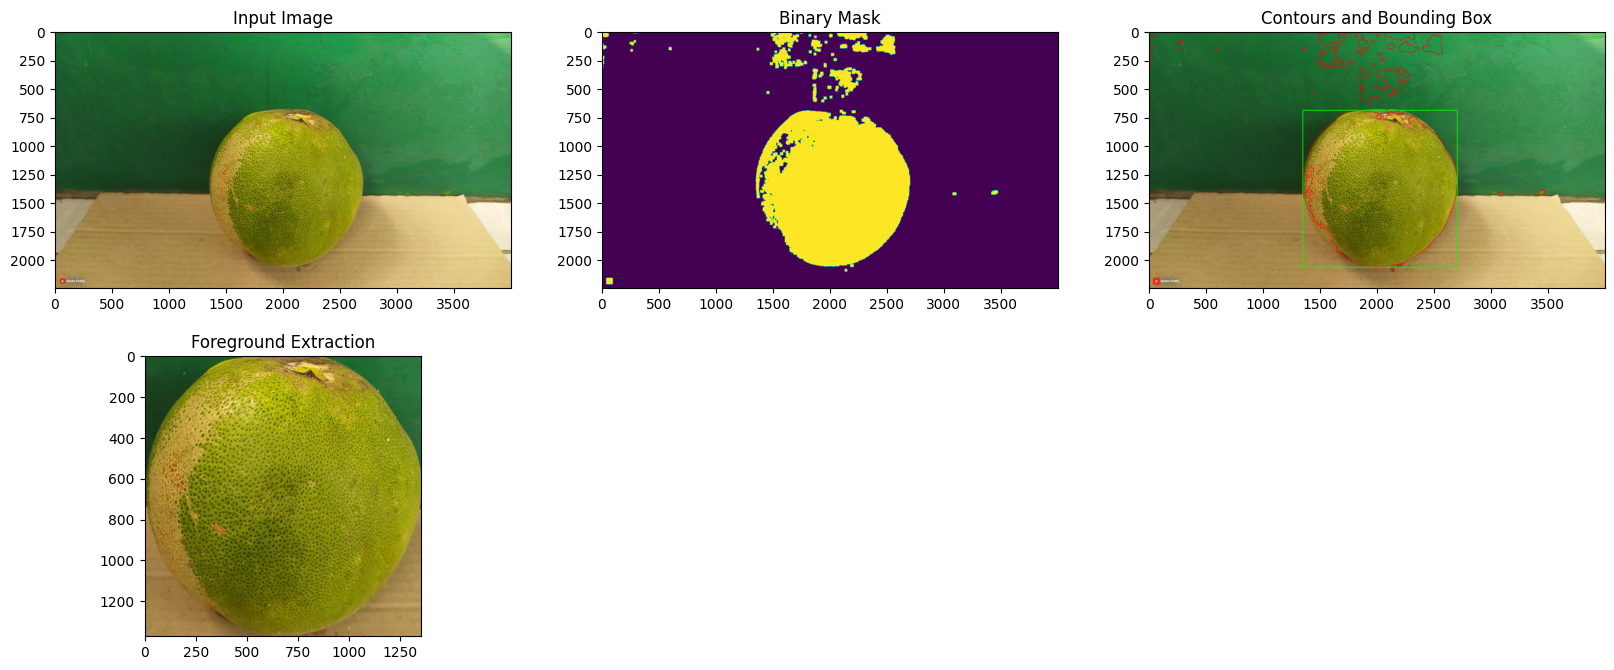

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/content/gdrive/MyDrive/SKRIPSI/IMG_20231206_074914.jpg")

# Convert the image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to HSV image
hsvImg = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create thresholding (parameters - green color range)
lower_green = (0, 201, 0)
upper_green = (141, 255, 255)
mask = cv2.inRange(hsvImg, lower_green, upper_green)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Erosion and Dilation
mask = cv2.erode(mask, None, iterations=3)  # Erosion
mask = cv2.dilate(mask, None, iterations=11)  # Dilation

# Create bool threshold
bMask = mask > 0

# Apply the threshold
clear = np.zeros_like(image, np.uint8)  # Create an empty image
clear[bMask] = image[bMask]  # Apply boolean mask to the original image

# Convert boolean threshold to uint8
bMask_uint8 = bMask.astype(np.uint8)

# Find contours
cont, _ = cv2.findContours(bMask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw contours on the original image
cont_img = cv2.drawContours(image.copy(), cont, -1, (255, 0, 0), 3)

# Extract the bounding box
if len(cont) != 0:
    c = max(cont, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(cont_img, (x, y), (x+w, y+h), (0, 255, 0), 5)

# Extract the foreground based on the bounding box
foreground = image[y:y+h, x:x+w]

# Display the results
plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 1), plt.imshow(image), plt.title("Input Image")
plt.subplot(2, 3, 2), plt.imshow(bMask_uint8), plt.title("Binary Mask")
plt.subplot(2, 3, 3), plt.imshow(cont_img), plt.title("Contours and Bounding Box")
plt.subplot(2, 3, 4), plt.imshow(foreground), plt.title("Foreground Extraction")
plt.show()


# Split dataframe

In [ ]:
# First, split 'data' into train and rest (test + validation)
x_train, x_test, y_train, y_test = train_test_split(dataset['filepaths'], dataset['labels'], test_size=0.2, random_state=123)

# Second, split the rest into test and validation
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=123)

# Create DataFrames for train_df, test_df, and valid_df
train_df = pd.DataFrame({'filepaths': x_train, 'labels': y_train})
test_df = pd.DataFrame({'filepaths': x_test, 'labels': y_test})
valid_df = pd.DataFrame({'filepaths': x_valid, 'labels': y_valid})

# Reset the index for each DataFrame
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  960   test_df length:  120   valid_df length:  120


In [ ]:
# List untuk menyimpan hasil preprocessing
output_directory = "/content/gdrive/MyDrive/SKRIPSI/ekstraksi/train_df"
processed_image = []

for img_path in train_df['filepaths']:
    # Construct the full path to the image file
    file_path = os.path.join(img_path)

    # Read the image from the filepath
    img = cv2.imread(file_path)

    # Convert the image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV image
    hsvImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Create thresholding (parameters - green color range)
    lower_green = (0, 201, 0)
    upper_green = (141, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Erosion and Dilation
    mask = cv2.erode(mask, None, iterations=3)  # Erosion
    mask = cv2.dilate(mask, None, iterations=11)  # Dilation

    # Create bool threshold
    bMask = mask > 0

    # Apply the threshold
    clear = np.zeros_like(img, np.uint8)  # Create an empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the original image

    # Convert boolean threshold to uint8
    bMask_uint8 = bMask.astype(np.uint8)

    # Find contours
    cont, _ = cv2.findContours(bMask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw contours on the original image
    cont_img = cv2.drawContours(img.copy(), cont, -1, (255, 0, 0), 3)

    # Extract the bounding box
    if len(cont) != 0:
        c = max(cont, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(cont_img, (x, y), (x+w, y+h), (0, 255, 0), 5)

    # Extract the foreground based on the bounding box
    foreground = img[y:y+h, x:x+w]

    # Convert the foreground back to BGR
    foreground_bgr = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR)

    # Construct a new filename based on the original filename
    filename = os.path.basename(file_path)
    new_filename = os.path.splitext(filename)[0] + "_feature.jpg"

    # Construct the full path to save the processed image
    save_path = os.path.join(output_directory, new_filename)

    # Save the processed image
    cv2.imwrite(save_path, foreground_bgr)

    # Append the saved filepath to the list
    processed_image.append(save_path)

# Menambahkan filepaths hasil preprocessing ke dalam DataFrame
train_df['processed_image'] = processed_image

In [ ]:
print(train_df.head())

                                           filepaths   labels  \
0  /content/gdrive/MyDrive/SKRIPSI/dataset/blondo...  blondok   
1  /content/gdrive/MyDrive/SKRIPSI/dataset/lalat/...    lalat   
2  /content/gdrive/MyDrive/SKRIPSI/dataset/sehat/...    sehat   
3  /content/gdrive/MyDrive/SKRIPSI/dataset/lalat/...    lalat   
4  /content/gdrive/MyDrive/SKRIPSI/dataset/sehat/...    sehat   

                                     processed_image  
0  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...  
1  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...  
2  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...  
3  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...  
4  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...  


In [ ]:
# Drop kolom dengan nama 'filepaths' langsung pada DataFrame asli
train_df.drop(columns=['filepaths'], inplace=True)

In [ ]:
print(train_df.head())

    labels                                    processed_image
0  blondok  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...
1    lalat  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...
2    sehat  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...
3    lalat  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...
4    sehat  /content/gdrive/MyDrive/SKRIPSI/ekstraksi/trai...


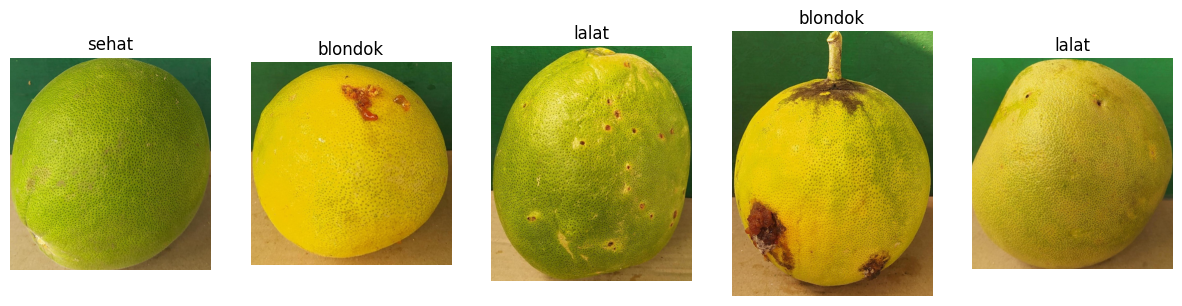

In [ ]:
# Ambil beberapa sampel dari DataFrame
samples = train_df.sample(n=5)  # Ubah n sesuai dengan jumlah sampel yang ingin ditampilkan

# Atur ukuran subplot
plt.figure(figsize=(15, 5))

# Iterasi melalui sampel
for i, (index, sample) in enumerate(samples.iterrows()):
    # Baca gambar yang telah diproses
    processed_image = cv2.imread(sample['processed_image'])

    # Tampilkan gambar di subplot
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title(sample['labels'])
    plt.axis('off')

# Tampilkan plot
plt.show()

In [ ]:
# List untuk menyimpan hasil preprocessing
output_directory = "/content/gdrive/MyDrive/SKRIPSI/ekstraksi/test_df"
processed_image = []

for img_path in test_df['filepaths']:
    # Construct the full path to the image file
    file_path = os.path.join(img_path)

    # Read the image from the filepath
    img = cv2.imread(file_path)

    # Convert the image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV image
    hsvImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Create mask (parameters - green color range)
    lower_green = (0, 201, 0)
    upper_green = (141, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Erosion and Dilation
    mask = cv2.erode(mask, None, iterations=3)  # Erosion
    mask = cv2.dilate(mask, None, iterations=11)  # Dilation

    # Create bool mask
    bMask = mask > 0

    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create an empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the original image

    # Convert boolean mask to uint8
    bMask_uint8 = bMask.astype(np.uint8)

    # Find contours
    cont, _ = cv2.findContours(bMask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw contours on the original image
    cont_img = cv2.drawContours(img.copy(), cont, -1, (255, 0, 0), 3)

    # Extract the bounding box
    if len(cont) != 0:
        c = max(cont, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(cont_img, (x, y), (x+w, y+h), (0, 255, 0), 5)

    # Extract the foreground based on the bounding box
    foreground = img[y:y+h, x:x+w]

    # Convert the foreground back to BGR
    foreground_bgr = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR)

    # Construct a new filename based on the original filename
    filename = os.path.basename(file_path)
    new_filename = os.path.splitext(filename)[0] + "_feature.jpg"

    # Construct the full path to save the processed image
    save_path = os.path.join(output_directory, new_filename)

    # Save the processed image
    cv2.imwrite(save_path, foreground_bgr)

    # Append the saved filepath to the list
    processed_image.append(save_path)

# Menambahkan filepaths hasil preprocessing ke dalam DataFrame
test_df['processed_image'] = processed_image

In [ ]:
# Drop kolom dengan nama 'processed_images' langsung pada DataFrame asli
test_df.drop(columns=['filepaths'], inplace=True)

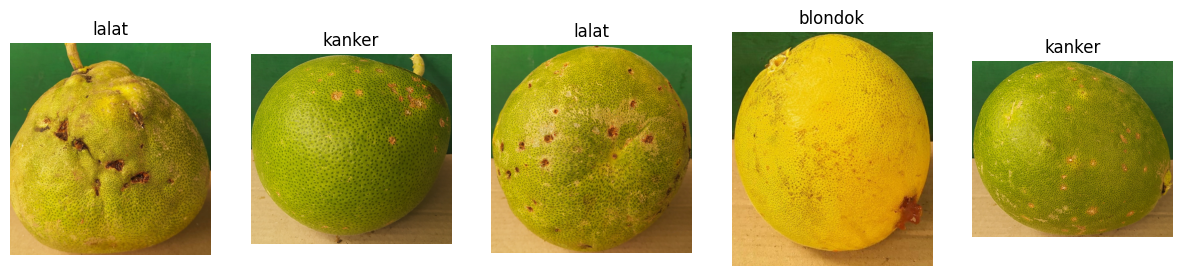

In [ ]:
# Ambil beberapa sampel dari DataFrame
samples = test_df.sample(n=5)  # Ubah n sesuai dengan jumlah sampel yang ingin ditampilkan

# Atur ukuran subplot
plt.figure(figsize=(15, 5))

# Iterasi melalui sampel
for i, (index, sample) in enumerate(samples.iterrows()):
    # Baca gambar yang telah diproses
    processed_image = cv2.imread(sample['processed_image'])

    # Tampilkan gambar di subplot
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title(sample['labels'])
    plt.axis('off')

# Tampilkan plot
plt.show()

In [ ]:
# List untuk menyimpan hasil preprocessing
output_directory = "/content/gdrive/MyDrive/SKRIPSI/ekstraksi/valid_df"
processed_image = []

for img_path in valid_df['filepaths']:
    # Construct the full path to the image file
    file_path = os.path.join(img_path)

    # Read the image from the filepath
    img = cv2.imread(file_path)

    # Convert the image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV image
    hsvImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Create mask (parameters - green color range)
    lower_green = (0, 201, 0)
    upper_green = (141, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Erosion and Dilation
    mask = cv2.erode(mask, None, iterations=3)  # Erosion
    mask = cv2.dilate(mask, None, iterations=11)  # Dilation

    # Create bool mask
    bMask = mask > 0

    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create an empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the original image

    # Convert boolean mask to uint8
    bMask_uint8 = bMask.astype(np.uint8)

    # Find contours
    cont, _ = cv2.findContours(bMask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw contours on the original image
    cont_img = cv2.drawContours(img.copy(), cont, -1, (255, 0, 0), 3)

    # Extract the bounding box
    if len(cont) != 0:
        c = max(cont, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(cont_img, (x, y), (x+w, y+h), (0, 255, 0), 5)

    # Extract the foreground based on the bounding box
    foreground = img[y:y+h, x:x+w]

    # Convert the foreground back to BGR
    foreground_bgr = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR)

    # Construct a new filename based on the original filename
    filename = os.path.basename(file_path)
    new_filename = os.path.splitext(filename)[0] + "_feature.jpg"

    # Construct the full path to save the processed image
    save_path = os.path.join(output_directory, new_filename)

    # Save the processed image
    cv2.imwrite(save_path, foreground_bgr)

    # Append the saved filepath to the list
    processed_image.append(save_path)

# Menambahkan filepaths hasil preprocessing ke dalam DataFrame
valid_df['processed_image'] = processed_image

In [ ]:
# Drop kolom dengan nama 'processed_images' langsung pada DataFrame asli
valid_df.drop(columns=['filepaths'], inplace=True)

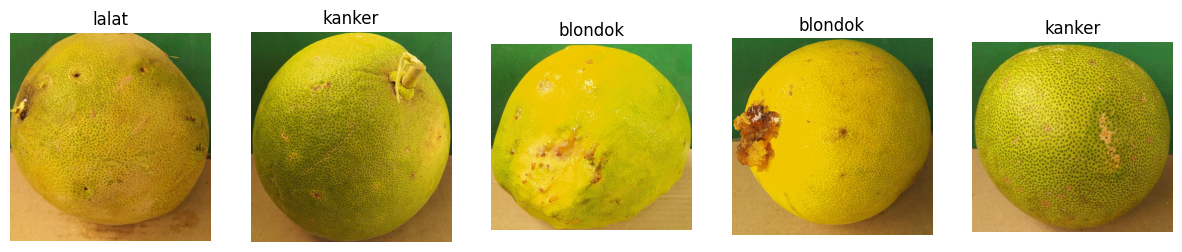

In [ ]:
# Ambil beberapa sampel dari DataFrame
samples = valid_df.sample(n=5)  # Ubah n sesuai dengan jumlah sampel yang ingin ditampilkan

# Atur ukuran subplot
plt.figure(figsize=(15, 5))

# Iterasi melalui sampel
for i, (index, sample) in enumerate(samples.iterrows()):
    # Baca gambar yang telah diproses
    processed_image = cv2.imread(sample['processed_image'])

    # Tampilkan gambar di subplot
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title(sample['labels'])
    plt.axis('off')

# Tampilkan plot
plt.show()

# create train, test, valid generators

In [ ]:
print(train_df.columns)
print(test_df.columns)
print(valid_df.columns)

Index(['labels', 'processed_image'], dtype='object')
Index(['labels', 'processed_image'], dtype='object')
Index(['labels', 'processed_image'], dtype='object')


In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
)

# Create train generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='processed_image',
    y_col='labels',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    shuffle=True,
    seed=123
)

# Data augmentation for the test (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)
# Create test generators
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='processed_image',
    y_col='labels',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

# Data augmentation for the validation (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
# Create validation generators
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='processed_image',
    y_col='labels',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle validation data
)

classes=list(train_generator.class_indices.keys())
print (classes)
class_count=len(classes)

Found 960 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
['blondok', 'kanker', 'lalat', 'sehat']


# create function to show some image examples

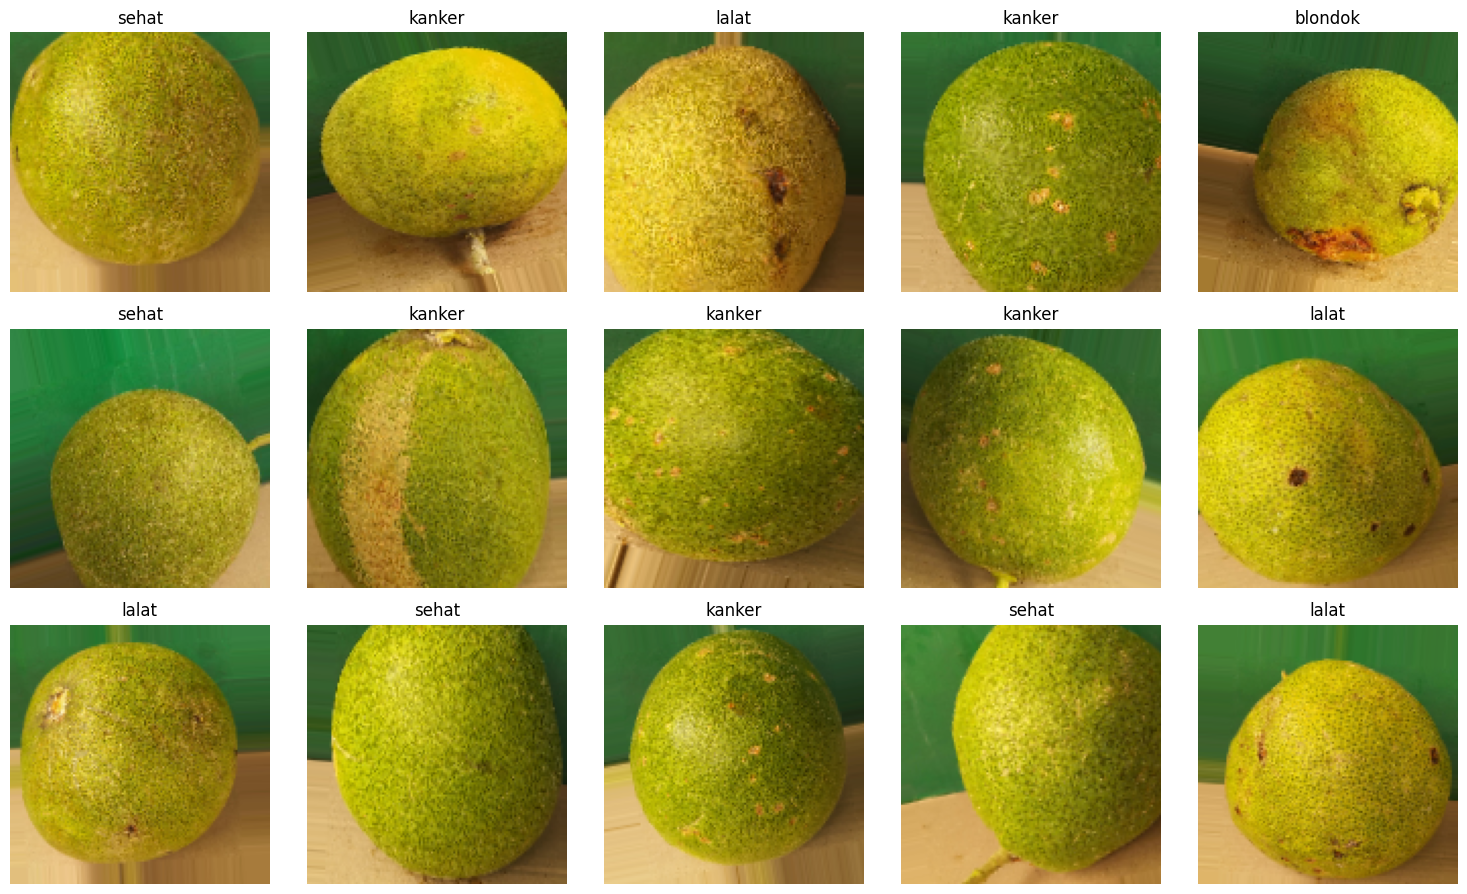

In [ ]:
def show_image_examples(data_generator, num_examples=15):
    # Get a batch of data from the generator
    batch = next(data_generator)

    # Extract images and labels from the batch
    images, labels = batch

    # Get class names from the generator
    class_names = list(data_generator.class_indices.keys())

    # Plot the image examples
    num_rows = (num_examples // 5) + 1
    plt.figure(figsize=(15, 3 * num_rows))
    for i in range(num_examples):
        plt.subplot(num_rows, 5, i + 1)

        # Convert the image to RGB if it's grayscale
        if images[i].shape[-1] == 1:
            plt.imshow(np.squeeze(images[i]), cmap='gray')
        else:
            plt.imshow(images[i])

        plt.title(class_names[labels[i].argmax()])
        plt.axis('off')

        if i >= len(images) - 1:
            break

    plt.tight_layout()
    plt.show()

# Show some image examples from the train generator
show_image_examples(train_generator, num_examples=15)


# Create Model

In [ ]:
base_model = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet", input_tensor=Input(shape=(128,128, 3)))
base_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
print(len(x_train))

960


In [ ]:
# Create the model architecture
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(4, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 16)          147472    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 8)           1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 8)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8)                 0

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# Train the model
history = model.fit(x=train_generator, epochs=30, batch_size=32, validation_data=valid_generator)

Epoch 1/30
30/30 [==============================] - 101s 3s/step - loss: 1.1459 - accuracy: 0.5177 - val_loss: 0.8545 - val_accuracy: 0.6917
Epoch 2/30
30/30 [==============================] - 87s 3s/step - loss: 0.7452 - accuracy: 0.7042 - val_loss: 0.6461 - val_accuracy: 0.7500
Epoch 3/30
30/30 [==============================] - 89s 3s/step - loss: 0.5330 - accuracy: 0.8062 - val_loss: 0.6209 - val_accuracy: 0.8000
Epoch 4/30
30/30 [==============================] - 86s 3s/step - loss: 0.5087 - accuracy: 0.8083 - val_loss: 0.5869 - val_accuracy: 0.8250
Epoch 5/30
30/30 [==============================] - 86s 3s/step - loss: 0.4877 - accuracy: 0.8365 - val_loss: 0.5243 - val_accuracy: 0.8583
Epoch 6/30
30/30 [==============================] - 88s 3s/step - loss: 0.4480 - accuracy: 0.8396 - val_loss: 0.5858 - val_accuracy: 0.7833
Epoch 7/30
30/30 [==============================] - 88s 3s/step - loss: 0.3722 - accuracy: 0.8750 - val_loss: 0.6527 - val_accuracy: 0.8000
Epoch 8/30
30/30 [=

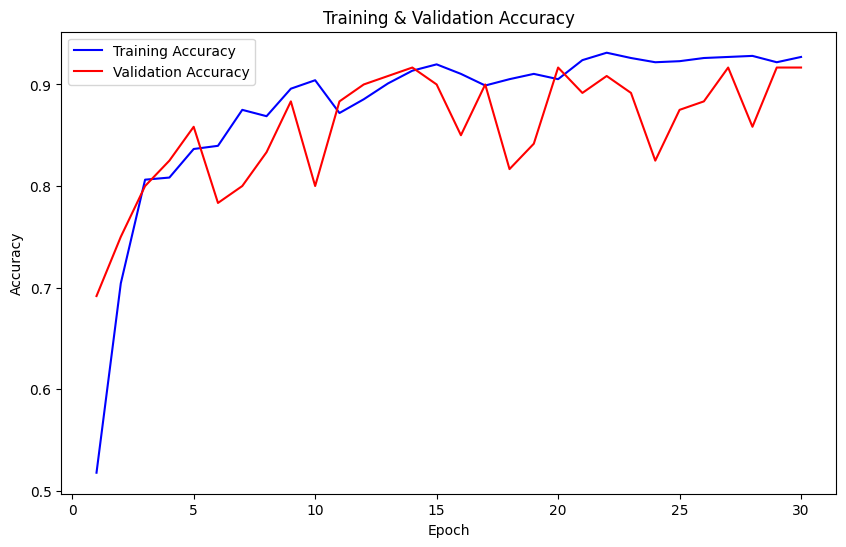

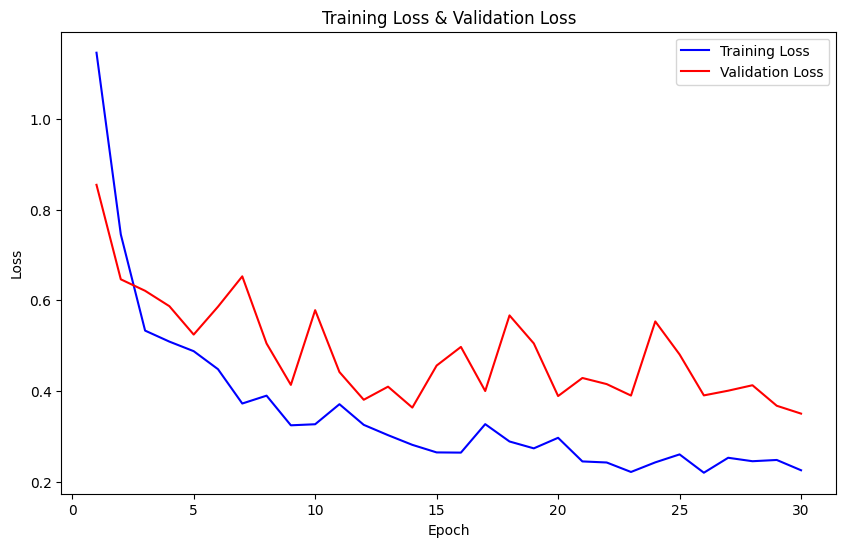

4/4 [==============================] - 16s 4s/step - loss: 0.2594 - accuracy: 0.9250
Accuracy on the test set is 92.50%


In [ ]:
# Assuming you have already trained the model for 30 epochs and stored the history object

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training Loss & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Assuming you have already defined test_gen

# Get the number of batches (steps) in the test generator
test_steps = len(test_generator)

# Get the first batch from the test generator to determine the batch size
test_batch = next(iter(test_generator))
test_batch_size = len(test_batch[0])

# Evaluate the model on the test set
results = model.evaluate(test_generator, batch_size=test_batch_size, verbose=1, steps=test_steps)

# Extract the accuracy from the results
accuracy = results[1] * 100

# Display the accuracy on the test set
msg = f'Accuracy on the test set is {accuracy:.2f}%'
print(msg)

In [ ]:
# Save the entire model to a file
model.save("/content/gdrive/MyDrive/SKRIPSI/Test3_Densenet121_fe.h5")

4/4 [==============================] - 13s 2s/step


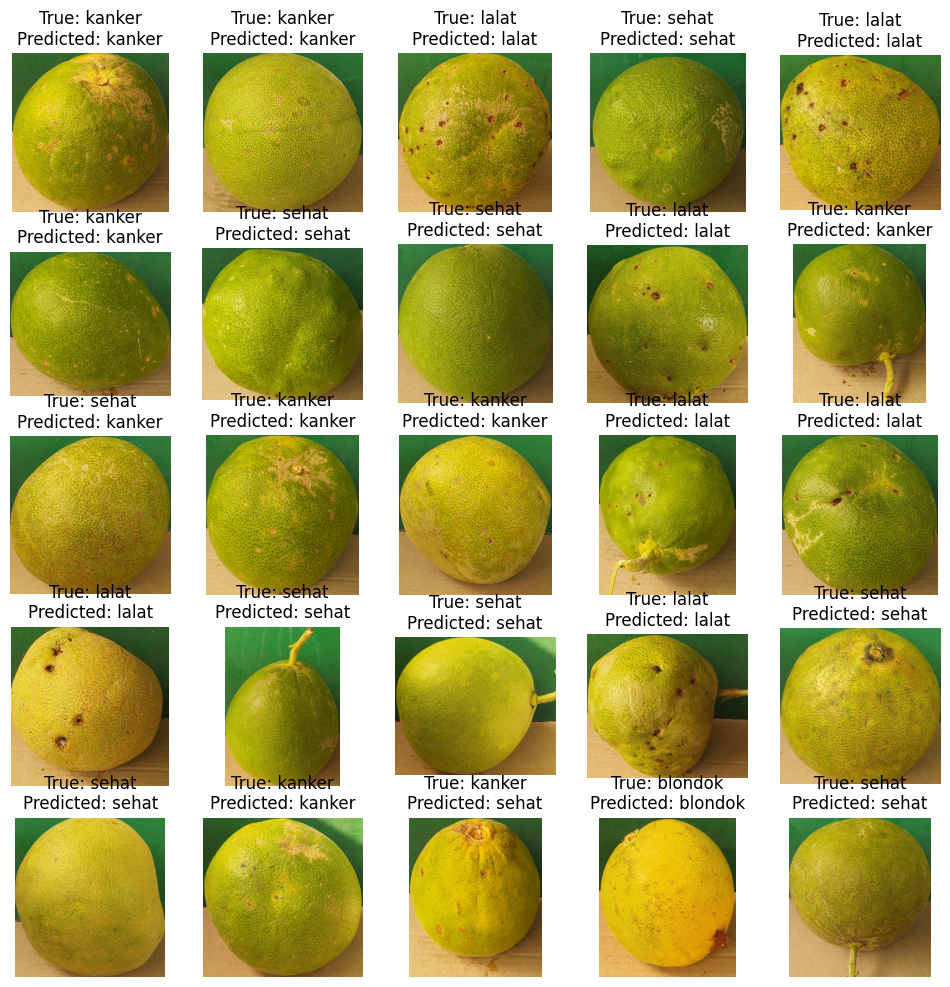

In [ ]:
# Assuming you have already trained and saved your model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/SKRIPSI/Test3_Densenet121_fe.h5")

# Predict the test set using the test generator
predictions = model.predict(test_generator)

# Convert predictions to labels
predicted_labels = [classes[i] for i in predictions.argmax(axis=1)]

# Extract corresponding test images
test_images = test_df['processed_image'].tolist()

# Create a DataFrame to store true labels, predicted labels, and corresponding test images
predictions_df = pd.DataFrame({'processed_image': test_images, 'true_labels': y_test, 'predicted_labels': predicted_labels})

# Function to display images with true and predicted labels
def display_images_with_predictions(predictions_df, num_images=25):
    selected_images = predictions_df.sample(num_images)

    fig, axes = plt.subplots(5, 5, figsize=(12, 12))

    for i, (index, row) in enumerate(selected_images.iterrows()):
        img_path = row['processed_image']
        true_label = row['true_labels']
        predicted_label = row['predicted_labels']

        # Load and display the image
        img = mpimg.imread(img_path)
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
        axes[i // 5, i % 5].axis('off')

    plt.show()

# Display 25 images with their true and predicted labels
display_images_with_predictions(predictions_df, num_images=25)

In [ ]:
# Calculate and display the percentage of correct predictions
correct_predictions = predictions_df['true_labels'] == predictions_df['predicted_labels']
accuracy = correct_predictions.sum() / len(correct_predictions) * 100
print(f'Correct Predictions: {correct_predictions.sum()} / {len(predictions_df)}')
print(f'Accuracy: {accuracy:.2f}%')

# Calculate and display the percentage of incorrect predictions
incorrect_predictions = ~correct_predictions
error_rate = incorrect_predictions.sum() / len(incorrect_predictions) * 100
print(f'Incorrect Predictions: {incorrect_predictions.sum()} / {len(predictions_df)}')
print(f'Error Rate: {error_rate:.2f}%')

Correct Predictions: 111 / 120
Accuracy: 92.50%
Incorrect Predictions: 9 / 120
Error Rate: 7.50%


4/4 [==============================] - 8s 2s/step


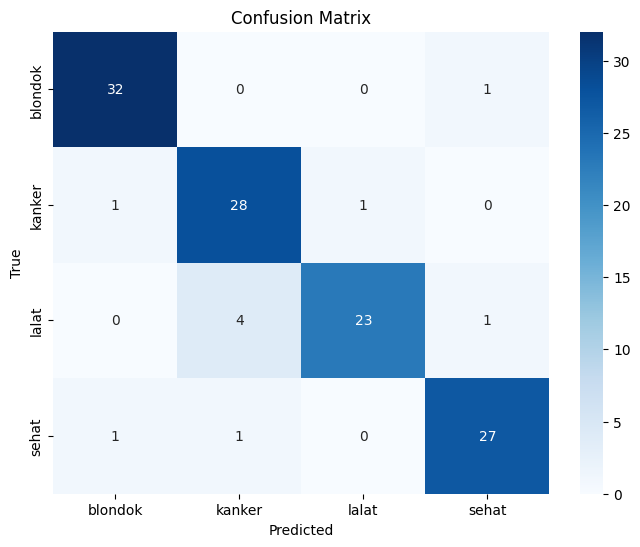

AUC Score: 0.9837794343407162
F1 Macro: 0.9149406592149772
Classification Report:
               precision    recall  f1-score   support

     blondok       0.94      0.97      0.96        33
      kanker       0.85      0.93      0.89        30
       lalat       0.96      0.82      0.88        28
       sehat       0.93      0.93      0.93        29

    accuracy                           0.92       120
   macro avg       0.92      0.91      0.91       120
weighted avg       0.92      0.92      0.92       120



In [ ]:
# Ambil prediksi probabilitas kelas dari model Anda
y_pred = model.predict(valid_generator)

# Ambil label asli (ground truth)
y_true = valid_generator.classes

# Ubah prediksi probabilitas menjadi kelas prediksi
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menghitung AUC Score
auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')  # 'ovr' untuk multiclass

# Menghitung F1 Macro
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Buat heatmap untuk visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("AUC Score:", auc_score)
print("F1 Macro:", f1_macro)

# Menampilkan Classification Report
class_names = list(valid_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


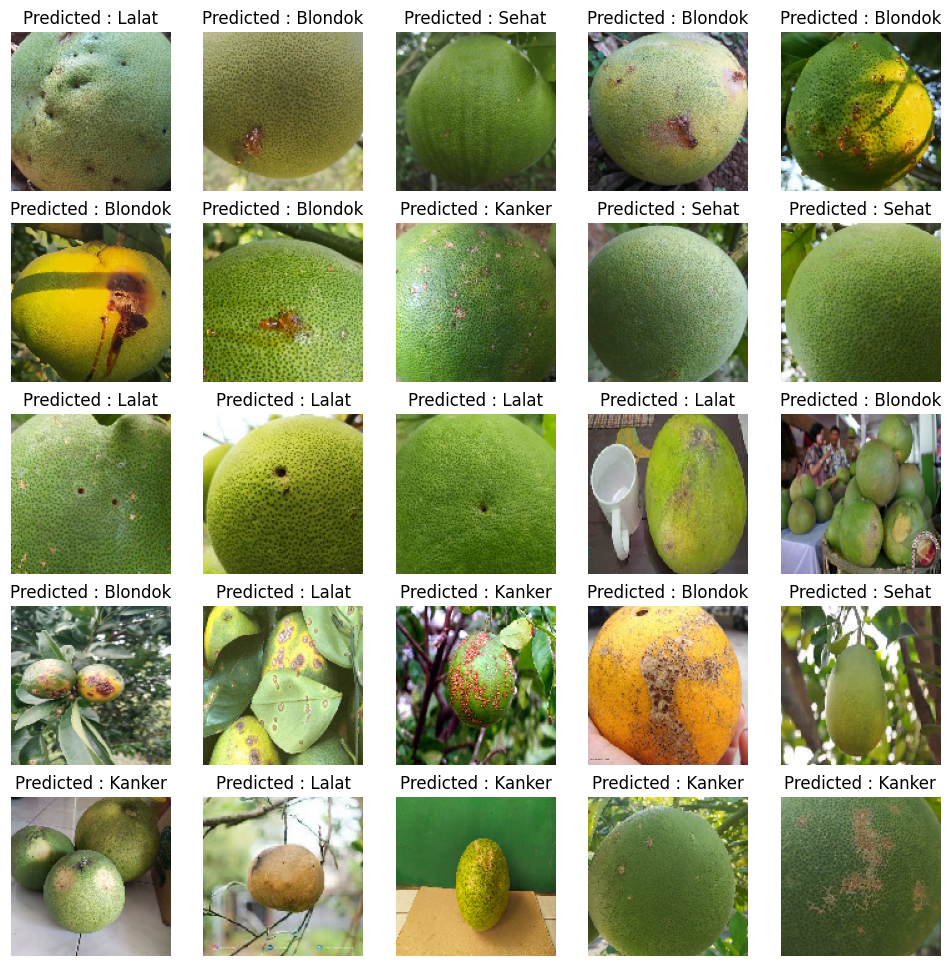

In [15]:
from tensorflow.keras.models import load_model

def predict_images_in_folder(model_path, folder_path):
    """
    Predicts the class labels for images in a folder using the trained model.

    Parameters:
        model_path (str): The path to the saved model file (.h5).
        folder_path (str): The folder path containing input images.

    Returns:
        predictions (list): List of tuples containing (predicted_label, input_img) for each image.
    """
    # Load the model
    model = load_model(model_path)

    predictions = []

    # Get the number of images in the folder
    num_images = len([filename for filename in os.listdir(folder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))])

    # Determine the number of rows and columns for subplot
    num_rows = int(np.ceil(num_images / 5))  # Adjust the number of columns as needed
    num_cols = 5

    # Create a subplot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    # Iterate through each file in the folder
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the input image
            img = image.load_img(image_path, target_size=(128, 128))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0  # Normalize pixel values

            # Make a prediction with verbose=0
            prediction_probs = model.predict(img_array, verbose=0)
            predicted_index = np.argmax(prediction_probs)

            # Get the class labels from the model
            class_labels = {0: 'Blondok', 1: 'Kanker', 2: 'Lalat', 3: 'Sehat'}  # Replace with your class labels

            # Map the predicted index to the class label
            predicted_label = class_labels[predicted_index]

            # Display the input image in subplot
            row = i // num_cols
            col = i % num_cols
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Predicted : {predicted_label}')
            axes[row, col].axis('off')

            predictions.append((predicted_label, img))

    plt.show()
    return predictions

# Example usage for a folder containing images
model_path = "/content/gdrive/MyDrive/SKRIPSI/Test3_Densenet121_fe.h5"
folder_path_to_predict = '/content/gdrive/MyDrive/SKRIPSI/drive-download'
predictions = predict_images_in_folder(model_path, folder_path_to_predict)

In [ ]:
print("Versi TensorFlow:", tf.__version__)

Versi TensorFlow: 2.10.0
